<a href="https://colab.research.google.com/github/myfirstmolly/random_walk/blob/main/randomwalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# input data

name of the file from which graph will be generated. note that input file should be in csv format in which 1st column represents starting point and is named 'source' and 2nd column represents destination point and is named 'target'. if none, the graph will be generated by default.

In [ ]:
file_name='git_combined.csv'

maximum random walk distance. if -1, the walk will continue until destination point is reached.

In [ ]:
max_walklen=-1

amount of random walks (epochs) between each pair of nodes.

In [ ]:
epochs=10

# code

In [ ]:
options = {
    'node_color': 'black',
    'edge_color': 'grey',
    'node_size': 10,
    'width': 1,
    'font_color': 'black'
}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

In [ ]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)

In [ ]:
def random_walk_nx(g, start_node, destination_node, epochs, max_walklen=-1):
  steps = []
  for k in range(epochs):
    c_index = start_node
    walklen = 0
    while max_walklen == -1 or walklen < max_walklen:
      walklen += 1
      neighbors = list(g.neighbors(c_index))
      sample = np.random.choice(neighbors)
      c_index = sample
      if sample == destination_node:
        steps.append(walklen)
        break
  return steps

In [ ]:
def mfht_matrix(g, epochs, max_walklen=-1):
  labels = list(g.nodes())
  walks_list = []
  mfht = np.zeros((len(labels), len(labels)))
  for start in range(len(labels)):
    walk = {}
    for dest in range(len(labels)):
      print(f'analyzing pair of nodes ({labels[start]}, {labels[dest]})...')
      walk_len = random_walk_nx(g, labels[start], labels[dest], epochs, max_walklen)
      mean = np.mean(walk_len)
      walk[dest] = {'mean' : mean, 'walk_len' : walk_len}
      mfht[start, dest] = mean
    walks_list.append(walk)
  return mfht, walks_list

In [ ]:
def estimate_degrees(g, walks_list):
  graph_degree = np.sum([val for (node, val) in g.degree()])
  return [round(graph_degree / walks_list[x][x]['mean']) for x in range(len(list(g.nodes())))]

In [ ]:
def connect(i, j, adj, degrees):
  if i != j and adj[i, j] == 0 and degrees[i] >= 1 and degrees[j] >= 1:
    adj[i, j] = 1
    adj[j, i] = 1
    degrees[i] = degrees[i] - 1
    degrees[j] = degrees[j] - 1

In [ ]:
def shortest_walks(walks_list, adj, degrees, indexes):
  for i in range(len(adj)):
    for j in range(len(adj)):
      if np.min(walks_list[i][j]['walk_len']) == 1:
        connect(i, j, adj, degrees)
  indexes = [idx for idx in indexes if degrees[idx] >= 1]

In [ ]:
def h_regular(mfht, adj, degrees, indexes, graph_degree):
  for j in indexes:
    permutation = sorted({k: mfht[k,j] for k in range(len(mfht))}.items(), key=lambda kv: kv[1])[1:degrees[j]+1]
    c = degrees[j] + np.sum([mfht[k,j] for k in range(len(adj)) if adj[j,k] > 0]) + np.sum([x[1] for x in permutation])
    if round(c) == graph_degree:
      for v in permutation:
        connect(v[0], j, adj, degrees)
  indexes = [idx for idx in indexes if degrees[idx] >= 1]

In [ ]:
def transition_probs(mfht, adj, degrees, indexes):
  h_inverted = np.linalg.inv(mfht.transpose())
  n = len(mfht)
  for i in indexes:
    v = 1 - mfht[:,i]
    h = h_inverted - np.outer(h_inverted[:,i], np.dot(v, h_inverted)) / (1 + np.dot(v, h_inverted[:,i]))
    l = mfht[i,:] - 1
    l[i] = 1
    res = h.dot(l)
    probs = sorted({k: res[k] for k in range(len(res))}.items(), key=lambda kv: kv[1])
    for pr in probs:
      if pr[1] > 0:
        connect(i, pr[0], adj, degrees)

In [ ]:
def recover_adj(g, mfht, walks_list):
  indexes = [idx for idx in range(len(list(g.nodes())))]
  for k in range(len(indexes)):
    mfht[k,k] = 0
  graph_degree = np.sum([val for (node, val) in g.degree()])
  adj = np.zeros((len(indexes), len(indexes)))
  degrees = estimate_degrees(g, walks_list)
  shortest_walks(walks_list, adj, degrees, indexes)
  h_regular(mfht, adj, degrees, indexes, graph_degree)
  transition_probs(mfht, adj, degrees, indexes)
  return adj

# results

<h2>input dataset</h2>

In [ ]:
if file_name != None:
  graph_edges = pd.read_csv(file_name)
  graph = nx.from_pandas_edgelist(graph_edges)
  graph_edges
else:
  graph = nx.erdos_renyi_graph(50, 0.1)

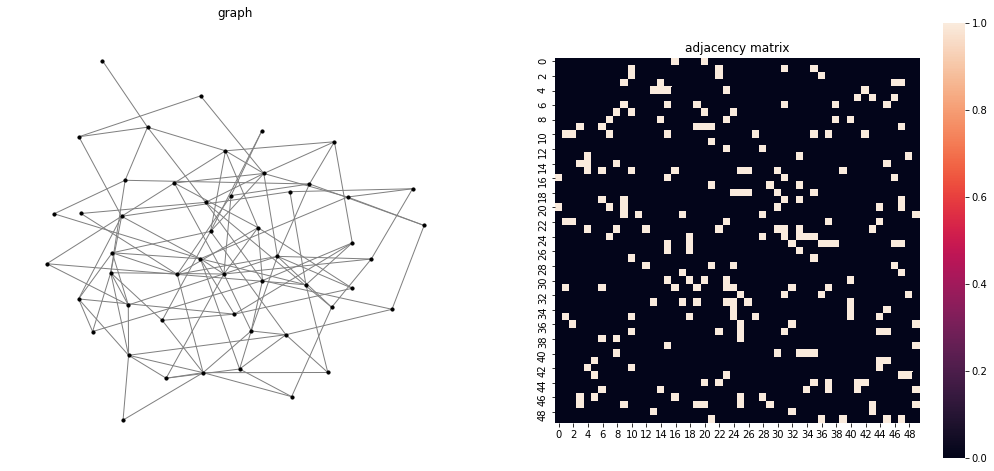

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
nx.draw_kamada_kawai(graph, ax=ax1, **options)
sns.heatmap(nx.to_numpy_array(graph), linewidths=0, square=True, ax=ax2)
ax1.set_title('graph')
ax2.set_title('adjacency matrix')
plt.show()

In [ ]:
mfht, walks_list = mfht_matrix(graph, epochs, max_walklen)

<h2>mean first hitting time matrix heatmap</h2>

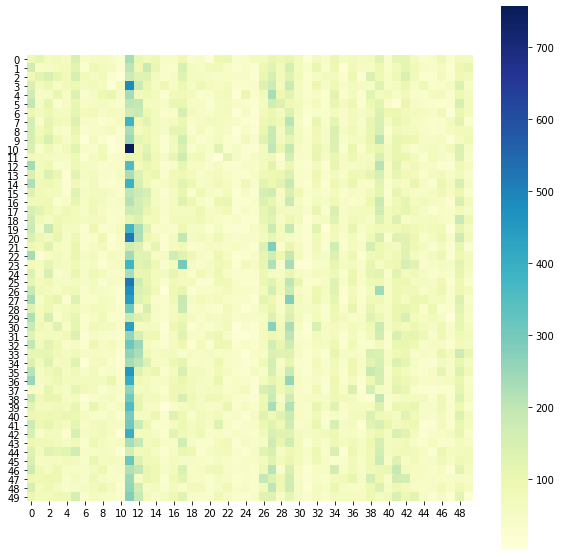

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(mfht, linewidths=0, square=True, cmap="YlGnBu")
plt.draw()

<h2>mean commute time heatmap</h2>

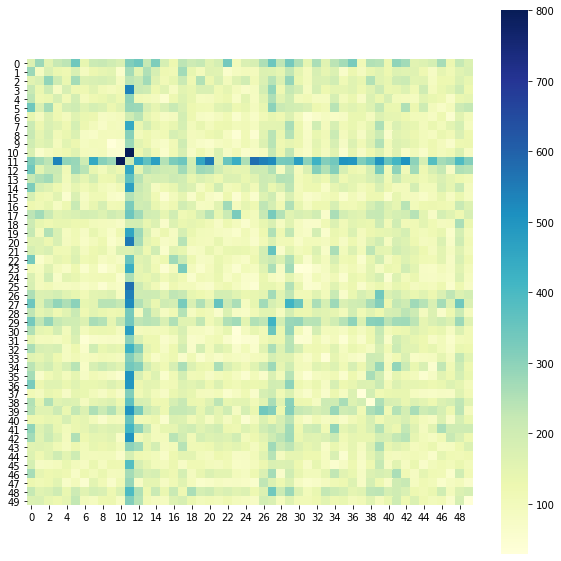

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(mfht + mfht.transpose(), linewidths=0, square=True, cmap="YlGnBu")
plt.draw()

In [ ]:
recovered_adj = recover_adj(graph, mfht, walks_list)

In [ ]:
recovered_graph = nx.from_pandas_adjacency(pd.DataFrame(recovered_adj, index=graph.nodes(), columns=graph.nodes()))

<h2>original graph vs recovered graph</h2>

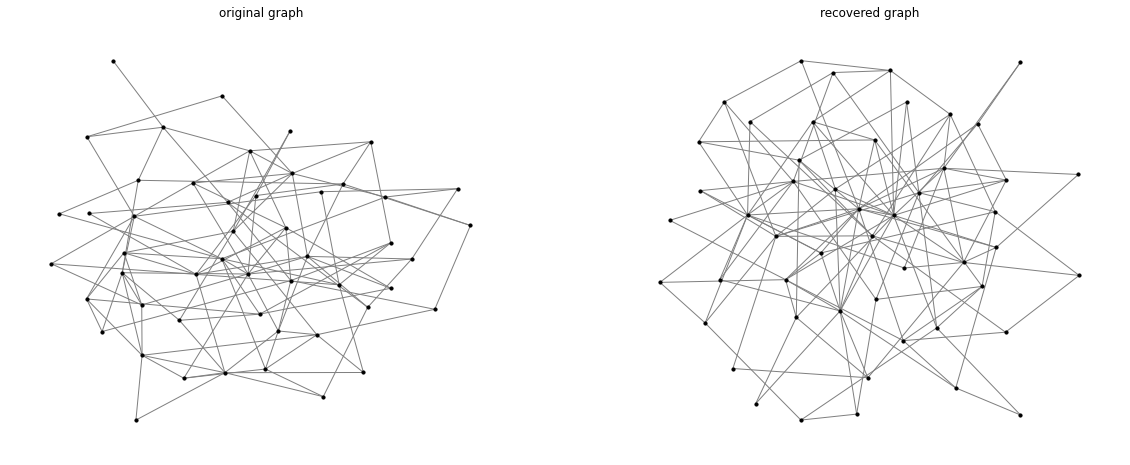

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
nx.draw_kamada_kawai(graph, ax=ax1, **options)
nx.draw_kamada_kawai(recovered_graph, ax=ax2, **options)
ax1.set_title('original graph')
ax2.set_title('recovered graph')
plt.draw()

In [ ]:
original_adj = nx.to_numpy_array(graph)

<h2>original vs recovered adjacency matrices</h2>

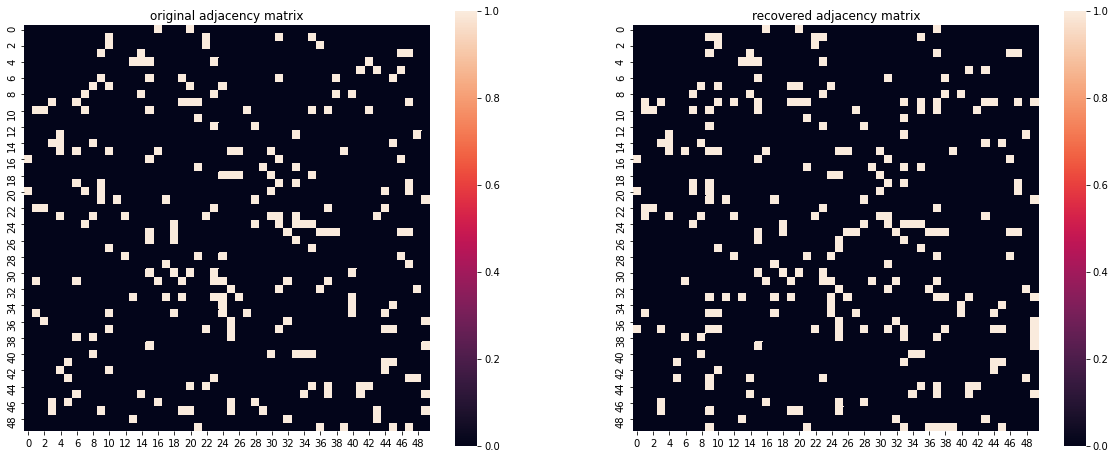

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
sns.heatmap(original_adj, linewidths=0, square=True, ax=ax1)
sns.heatmap(recovered_adj, linewidths=0, square=True, ax=ax2)
ax1.set_title('original adjacency matrix')
ax2.set_title('recovered adjacency matrix')
plt.draw()

<h2>confusion matrix and metrics</h2>

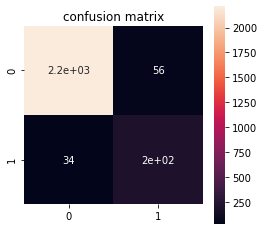

In [ ]:
from sklearn.metrics import confusion_matrix
true = original_adj.flatten()
predict = recovered_adj.flatten()
conf_matrix = confusion_matrix(true, predict)
plt.figure(figsize=(4, 4))
plt.title('confusion matrix')
sns.heatmap(conf_matrix, annot=True, linewidths=0, square=True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
report = classification_report(true, predict, target_names=['class 0', 'class 1'], output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
class 0,0.984862,0.975309,0.980062,2268.000
class 1,0.779528,0.853448,0.814815,232.000
accuracy,0.964000,0.964000,0.964000,0.964
macro avg,0.882195,0.914378,0.897438,2500.000
weighted avg,0.965807,0.964000,0.964727,2500.000


<h2>output</h2>

In [ ]:
out = nx.to_pandas_edgelist(graph)
out.to_csv('graph_out.csv', index=False)

In [ ]:
pd.read_csv('graph_out.csv')

,source,target
0,0,16
1,0,20
2,1,10
3,1,22
4,1,31
...,...,...
111,42,44
112,43,47
113,43,48
114,45,49
